1. Install Dependencies and Setup

In [3]:
import tensorflow as tf
import os
import cv2
import imghdr
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from PIL import Image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.callbacks import TensorBoard
import datetime
import random
random.seed(42)

C:\Users\Asus\AppData\Local\Temp\ipykernel_14928\2599626068.py:4: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


2. Remove dodgy images

In [4]:
data_dir = 'Data/2_classes_Brain_tumor' 

In [5]:
# image_exts = ['jpeg','jpg', 'bmp', 'png']

In [6]:
# for image_class in os.listdir(data_dir): 
#     for image in os.listdir(os.path.join(data_dir, image_class)):
#         image_path = os.path.join(data_dir, image_class, image)
#         try: 
#             img = cv2.imread(image_path)
#             tip = imghdr.what(image_path)
#             if tip not in image_exts: 
#                 print('Image not in ext list {}'.format(image_path))
#                 os.remove(image_path)
#         except Exception as e: 
#             print('Issue with image {}'.format(image_path))
#             # os.remove(image_path)

3. Load Data

In [7]:
data = tf.keras.utils.image_dataset_from_directory('Data/2_classes_Brain_tumor')

Found 2999 files belonging to 2 classes.


In [8]:
# tf.keras.preprocessing.image_dataset_from_directory(
#     directory,
#     labels='inferred',
#     label_mode='int',
#     class_names=None,
#     color_mode='rgb',
#     batch_size=32,
#     image_size=(256, 256),
#     shuffle=True,
#     seed=None,
#     validation_split=None,
#     subset=None,
#     interpolation='bilinear',
#     follow_links=False,
#     crop_to_aspect_ratio=False,
#     pad_to_aspect_ratio=False,
#     data_format=None,
#     verbose=True
# )

In [9]:
print(len(data))

94


In [10]:
data_iterator = data.as_numpy_iterator()
data_iterator

NumpyIterator(iterator=<tensorflow.python.data.ops.iterator_ops.OwnedIterator object at 0x000001FD01081CD0>)

In [11]:
batch = data_iterator.next()
batch

(array([[[[0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
          [0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
          [1.0000000e+00, 1.0000000e+00, 1.0000000e+00],
          ...,
          [0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
          [1.0208855e+00, 1.0208855e+00, 1.0208855e+00],
          [0.0000000e+00, 0.0000000e+00, 0.0000000e+00]],
 
         [[0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
          [1.3460922e-01, 1.3460922e-01, 1.3460922e-01],
          [1.3867188e-01, 1.3867188e-01, 1.3867188e-01],
          ...,
          [6.7710876e-03, 6.7710876e-03, 6.7710876e-03],
          [0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
          [8.6132812e-01, 8.6132812e-01, 8.6132812e-01]],
 
         [[0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
          [0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
          [2.0000000e+00, 2.0000000e+00, 2.0000000e+00],
          ...,
          [7.7910156e+00, 7.7910156e+00, 7.7910156e+00],
          [2.8125000e+00, 2.8125000e+

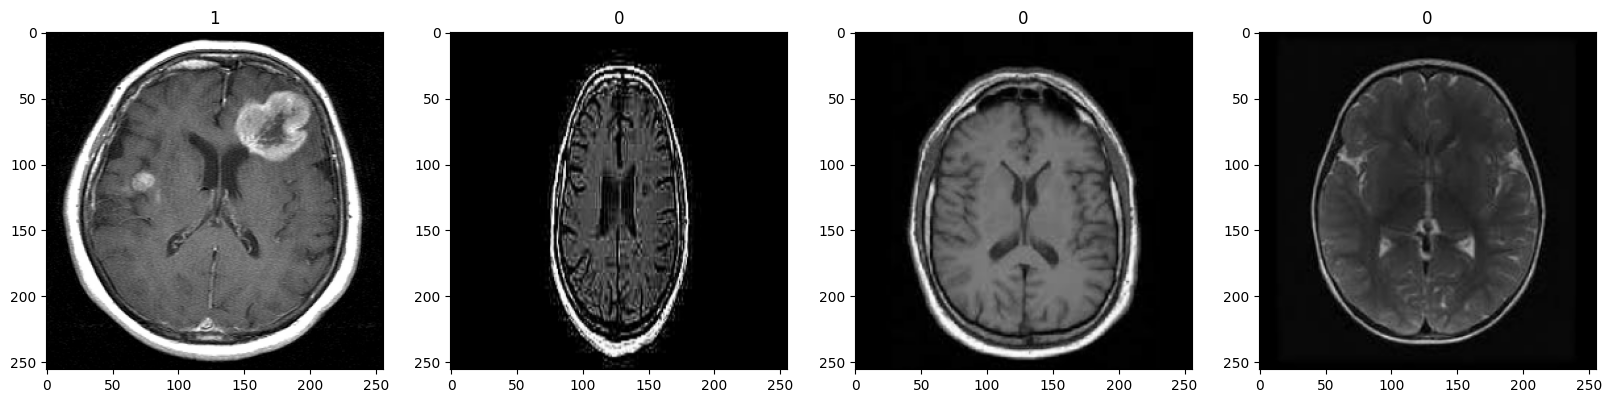

In [12]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

4. Scale Data

In [13]:
data = data.map(lambda x,y: (x/255, y))

In [14]:
data.as_numpy_iterator().next()

(array([[[[0.        , 0.16078432, 0.41568628],
          [0.03688725, 0.20557599, 0.45520833],
          [0.08333334, 0.24877451, 0.4922794 ],
          ...,
          [0.        , 0.20392157, 0.34901962],
          [0.        , 0.20392157, 0.34901962],
          [0.        , 0.20392157, 0.34901962]],
 
         [[0.01531863, 0.19142157, 0.41568628],
          [0.00846402, 0.17960612, 0.3986012 ],
          [0.00404747, 0.15698242, 0.36811477],
          ...,
          [0.        , 0.20392157, 0.3758272 ],
          [0.        , 0.20392157, 0.3758272 ],
          [0.        , 0.20392157, 0.3758272 ]],
 
         [[0.04960172, 0.2260723 , 0.3893076 ],
          [0.01637848, 0.18504758, 0.34301326],
          [0.01545171, 0.17456342, 0.32974735],
          ...,
          [0.        , 0.19261642, 0.43676472],
          [0.        , 0.19261642, 0.43676472],
          [0.        , 0.19261642, 0.43676472]],
 
         ...,
 
         [[0.02261029, 0.02714461, 0.00376838],
          [0.02261

5. Split Data

In [15]:
dataset = []
labels = []

INPUT_SIZE = (256,256)

label_mapping = {
    'no': 0, 
    'yes': 1
}

for image_class in os.listdir(data_dir): 
    class_index = label_mapping[image_class]
    class_path = os.path.join(data_dir, image_class)
    for image in os.listdir(class_path):
        image_path = os.path.join(class_path, image)
        if image_path.split('.')[-1] == 'jpg':
            img = cv2.imread(image_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, INPUT_SIZE)
            dataset.append(img)  
            labels.append(class_index)

dataset = np.array(dataset)
labels = np.array(labels)

x_train, x_test, y_train, y_test = train_test_split(dataset, labels, test_size=0.2, random_state=42)
#test_size = 0.2: 20% của dữ liệu sẽ được chọn ngãu nhiên và sử dụng cho tập kiểm tra, 80% còn lại sẽ được sử dụng cho tập huấn luyện
#random_state = 0: Qúa trình ngẫu nhiên sẽ được khởi tạo với seed 0 -> muốn tái tạo kết quả hoặc so sánh kết quả giữa các phương pháp hoặc mô hình khác nhau.

In [16]:
# Reshape = (n, image_width, image_height, n_channel)
print(x_train.shape)
print(y_train.shape)

print(x_test.shape)
print(y_test.shape)

(2399, 256, 256, 3)
(2399,)
(600, 256, 256, 3)
(600,)


In [17]:
print(y_train)

[1 1 1 ... 0 0 0]


In [18]:
print(y_test)

[0 0 0 1 0 0 1 0 1 1 1 0 1 1 0 1 1 0 1 1 1 0 0 1 0 0 0 1 1 0 0 0 0 0 1 1 1
 0 0 0 0 0 1 0 0 0 0 0 1 0 0 1 1 0 1 1 1 1 0 1 0 0 1 0 0 1 1 1 1 0 0 0 1 0
 0 1 1 0 1 0 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 1 1 0 0 1 1 1 0 0 0 1 1 0 0 1 1
 0 0 1 1 1 1 0 1 0 1 0 1 1 1 0 1 0 1 1 1 1 1 1 1 0 0 1 0 0 1 0 1 1 0 0 1 0
 1 0 0 1 1 1 0 1 0 1 1 0 0 0 1 1 1 1 1 1 0 0 1 0 1 1 0 1 0 0 0 1 1 1 1 0 0
 1 1 1 0 1 1 0 0 0 1 0 0 1 1 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 1 1 0 1 1 0 1 1
 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 1 0 0 1 1 0 1 0 0 0 1 0
 1 1 0 0 0 0 1 1 0 0 0 0 1 1 0 0 0 1 0 1 1 0 1 1 1 1 1 1 1 0 1 0 1 0 0 1 0
 0 1 1 1 1 0 0 1 1 1 0 1 1 1 0 1 1 0 1 1 0 1 0 0 0 1 0 0 0 0 1 0 0 0 1 1 0
 1 0 1 1 0 1 0 0 0 0 1 0 1 1 0 0 0 1 0 0 1 1 1 0 1 1 1 0 0 0 1 1 1 0 0 1 0
 0 1 1 0 1 0 0 1 1 1 1 1 1 0 1 0 1 1 0 1 1 1 1 1 1 1 1 0 0 0 1 0 0 0 0 1 1
 1 0 0 0 0 1 0 1 1 1 1 0 1 0 0 0 0 0 1 1 0 1 1 1 0 0 1 1 1 0 0 0 0 1 1 0 1
 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 1 0 1 1 1 0 1 0 0 1 0 0 1 0
 1 1 1 1 0 1 1 0 0 0 1 1 

6. Build Deep Learning Model

In [19]:
model = Sequential()

In [20]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

c:\Users\Asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [21]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [22]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     3,686,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,696,625 (14.10 MB)

 Trainable params: 3,696,625 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

7. Train

In [23]:
from keras.utils import to_categorical
from sklearn.preprocessing import normalize

In [24]:
logdir='logs'

In [25]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [26]:

tensorboard_callback = TensorBoard(log_dir=logdir, histogram_freq=1)

hist = model.fit(x_train, y_train, epochs=20, validation_data=(x_test, y_test), callbacks=[tensorboard_callback])


Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 41s 522ms/step - accuracy: 0.6871 - loss: 17.7182 - val_accuracy: 0.8050 - val_loss: 0.4159
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 17s 191ms/step - accuracy: 0.8597 - loss: 0.3338 - val_accuracy: 0.8983 - val_loss: 0.2948
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 13s 175ms/step - accuracy: 0.9420 - loss: 0.1608 - val_accuracy: 0.9250 - val_loss: 0.3008
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 15s 202ms/step - accuracy: 0.9795 - loss: 0.0581 - val_accuracy: 0.9367 - val_loss: 0.2485
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 14s 184ms/step - accuracy: 0.9937 - loss: 0.0257 - val_accuracy: 0.9333 - val_loss: 0.2855
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 182ms/step - accuracy: 0.9987 - loss: 0.0171 - val_accuracy: 0.9167 - val_loss: 0.4015
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 14s 184ms/step - accuracy: 0.9938 - loss: 0.0220 - val_accuracy: 0.9617 - val_loss: 0.2857
Epoch 8/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 13s 171ms/step - accuracy: 0.9969 - loss: 0.0075 - val_acc

8. Plot Performance

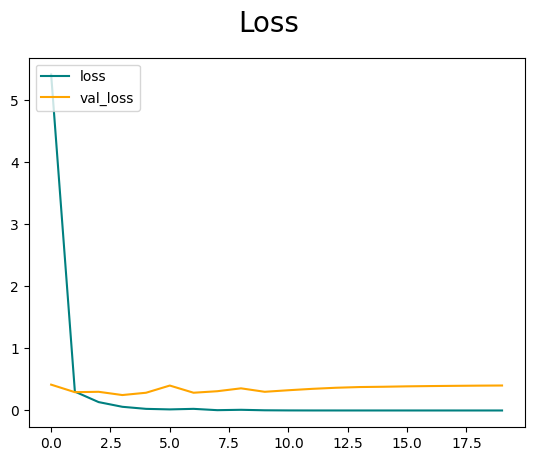

In [27]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

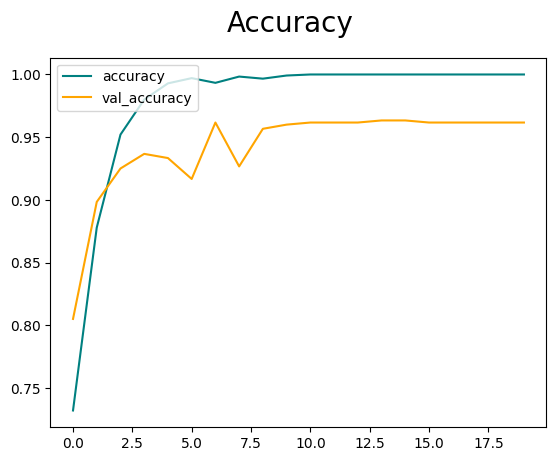

In [28]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

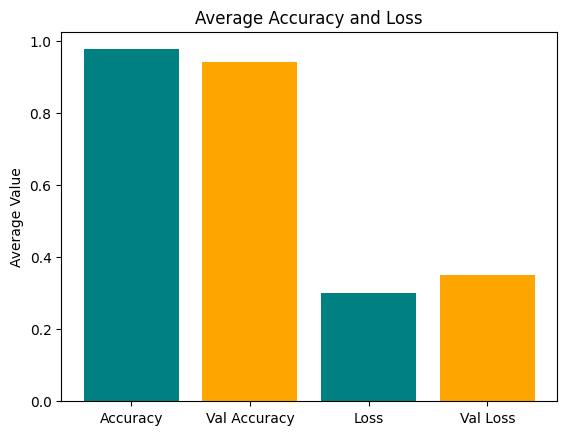

In [29]:
import numpy as np

avg_accuracy = np.mean(hist.history['accuracy'])
avg_val_accuracy = np.mean(hist.history['val_accuracy'])
avg_loss = np.mean(hist.history['loss'])
avg_val_loss = np.mean(hist.history['val_loss'])

fig, ax = plt.subplots()
ax.bar(['Accuracy', 'Val Accuracy', 'Loss', 'Val Loss'], [avg_accuracy, avg_val_accuracy, avg_loss, avg_val_loss], color=['teal', 'orange', 'teal', 'orange'])
ax.set_ylabel('Average Value')
ax.set_title('Average Accuracy and Loss')

plt.show()

In [30]:
avg_accuracy = np.mean(hist.history['accuracy'])
avg_val_accuracy = np.mean(hist.history['val_accuracy'])
avg_loss = np.mean(hist.history['loss'])
avg_val_loss = np.mean(hist.history['val_loss'])

print(f'Average Accuracy: {avg_accuracy}')
print(f'Average Validation Accuracy: {avg_val_accuracy}')
print(f'Average Loss: {avg_loss}')
print(f'Average Validation Loss: {avg_val_loss}')

Average Accuracy: 0.9759691566228866
Average Validation Accuracy: 0.9419999867677689
Average Loss: 0.2999372151903117
Average Validation Loss: 0.3490221545100212


9. Đánh giá mô hình

In [31]:
result=model.predict(x_test)

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step


In [32]:
ket_qua=[]
for i in result:
    if i>0.5: ket_qua.append(1)
    else: ket_qua.append(0)

In [33]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

              precision    recall  f1-score   support

           0       0.96      0.96      0.96       314
           1       0.96      0.96      0.96       286

    accuracy                           0.96       600
   macro avg       0.96      0.96      0.96       600
weighted avg       0.96      0.96      0.96       600



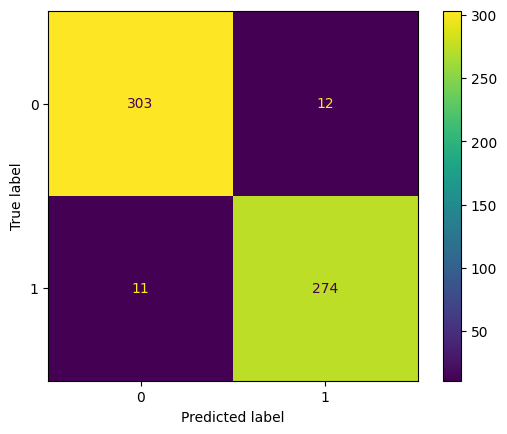

In [34]:
print(classification_report(ket_qua, y_test))
cm=confusion_matrix(y_test, ket_qua)
cm_display = ConfusionMatrixDisplay(cm)

cm_display.plot(values_format='d')

plt.show()

In [35]:
# Danh sách ket_qua được đưa vào để chuẩn hóa
ket_qua_normalized = []

# Thực hiện chuẩn hóa theo ngưỡng 0.5
for i in ket_qua:
    if i > 0.5:
        ket_qua_normalized.append(1)
    else:
        ket_qua_normalized.append(0)

print(ket_qua_normalized)

[0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 

              precision    recall  f1-score   support

           0       0.96      0.96      0.96       314
           1       0.96      0.96      0.96       286

    accuracy                           0.96       600
   macro avg       0.96      0.96      0.96       600
weighted avg       0.96      0.96      0.96       600



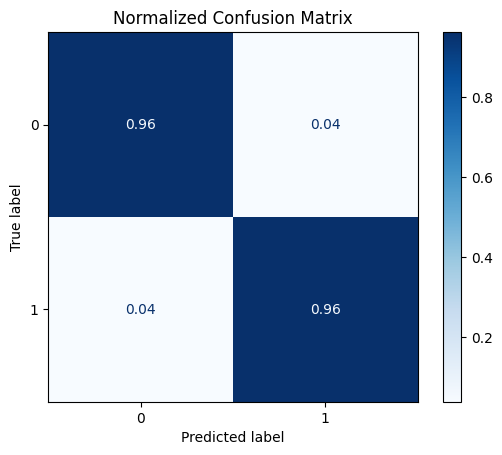

In [36]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Thay thế "ket_qua_normalized" bằng kết quả dự đoán đã được normalized
print(classification_report(ket_qua_normalized, y_test))
cm = confusion_matrix(y_test, ket_qua_normalized)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

cm_display = ConfusionMatrixDisplay(confusion_matrix=cm_normalized)
cm_display.plot(cmap=plt.cm.Blues, values_format='.2f')

plt.title('Normalized Confusion Matrix')
plt.show()

10. Test

In [37]:
import cv2

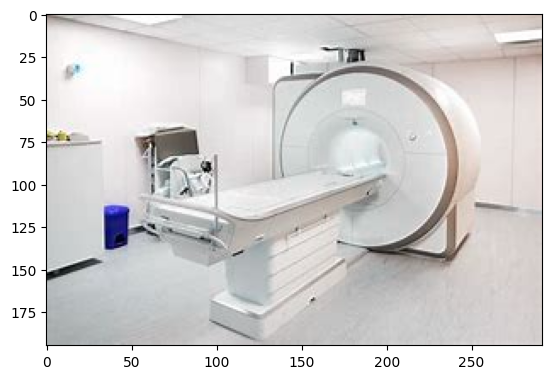

In [58]:
img = cv2.imread('Data/2_classes_Brain_tumor/OIP.jpg')
plt.imshow(img)
plt.show()

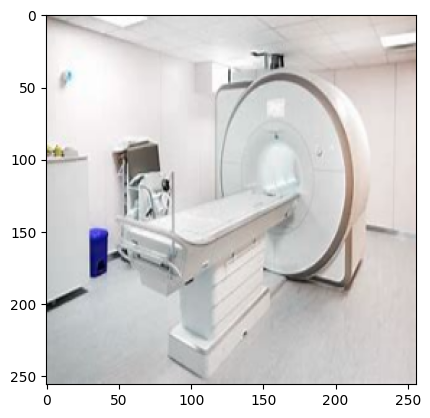

In [59]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [60]:
y_pred = model.predict(np.expand_dims(resize/256, 0))
y_pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


array([[0.49565294]], dtype=float32)

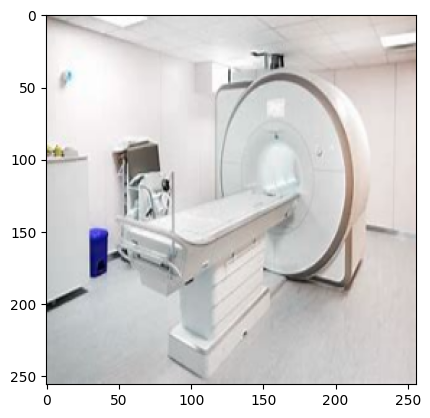

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
[[0.49565294]]
no tumor


In [61]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

y_pred = model.predict(np.expand_dims(resize/256, 0))
print(y_pred)

if y_pred > 0.5: 
    print(f'yes tumor')
else:
    print(f'no tumor')

11. Save the Model

In [42]:
from tensorflow.keras.models import load_model

In [43]:
model.save(os.path.join('models','imageclassifier.h5'))

In [44]:
new_model = load_model('models/imageclassifier.h5')

In [45]:
new_model.predict(np.expand_dims(resize/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


array([[0.5494504]], dtype=float32)